<a href="https://colab.research.google.com/github/jegraham/Phase-2-Cluster-Implementations/blob/BIRCH/Graham%2C_Jessica_Clustering_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GNN Implementation (Phase 1)

This is the initial GNN implementation using encoders and decoders.



To Prevent Timeout CTRL+SHIFT+J Enter this Javascript:

***function ClickConnect() {***
  ***console.log("Clicked on star button");***
  ***document.querySelector("iron-icon#star-icon").click();***
***}***
***setInterval(ClickConnect, 1200000); // Invoke every 2 minutes***


## Import Libraries

In [88]:
import os
import os.path as osp
import shutil # -> For copying a directory
import pandas as pd # -> For data structure and file manipulation
import random

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [132]:
#Import the remaining files as needed
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

#!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#print('uninstall')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install scikit-learn
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}.html



import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist, squareform
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, Birch, OPTICS, AgglomerativeClustering, DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, InMemoryDataset, download_url
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit
import torch.nn.functional as F


2.0.1+cu118
Using cuda.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Check GPU

In [90]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jun 26 21:52:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |    901MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check Memory

In [91]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [92]:
# Import the Data
from google.colab import files
uploaded = files.upload()
# uploaded = https://drive.google.com/file/d/1Ej2lijwlKM7pri5ebQ5hVl-Z5OtvWNbz/view?usp=share_link

file_name = next(iter(uploaded))
print(file_name)
df = pd.read_csv(file_name)
df = df.reset_index(drop=True)

Saving May 4th Dataset Car and Tower  - Sheet1 (1).csv to May 4th Dataset Car and Tower  - Sheet1 (1) (1).csv
May 4th Dataset Car and Tower  - Sheet1 (1).csv


## Setup Dataset


In [ ]:
# Generate a graph
# Inspirations taken from - Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb

# Create an empty graph and lists
G = nx.Graph()
edge_index = []


# iterate through rows and add nodes to the graph
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])


# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'], errors='coerce')

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor


# add nodes to the graph with their features
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Loop row by row to add the edges to the graph
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)):
        if i == j:
            continue

        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

        if 0 < dist <= 500:
          distances.append((dist, j))
        # print(distance)

   distances.sort()

   for k in range(len(distances)):
       G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)


In [ ]:
# Plotting Graph (Version 1)
X = df[['X', 'Y']].values

# create a layout for the graph nodes
pos = dict(zip(range(len(df)), X))

# draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['X'], df['Y'], s=20, color='grey')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='b', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()


In [ ]:
# Plotting Graph (Version 2)

# generate a layout for the graph nodes
pos = nx.spring_layout(G, k=1.1, iterations=50, seed=42)
fig, ax = plt.subplots(figsize=(15, 15))


# draw the nodes of the graph
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='pink', alpha=0.7, edgecolors='pink')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# draw the edges of the graph
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# get the edge weights as a dictionary
edge_labels = nx.get_edge_attributes(G, 'weight')

# draw the edge weights as labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# display the graph

plt.show()

In [ ]:
# Plotting Graph (Version 3)
# Displaying the Graph Edges Similar

# specify node positions
pos = nx.spring_layout(G,k=1, iterations=50, seed=42)
fig, ax = plt.subplots(figsize=(15, 15))

# draw nodes
nx.draw_networkx_nodes(G, pos)

# draw node labels
nx.draw_networkx_labels(G, pos)

# draw edges
nx.draw_networkx_edges(G, pos)


plt.show()

print(G)

## InMemory Dataset

Convert Dataset to same format as Planetoid - https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

In [ ]:
#InMemoryDataset
class MyDataset(InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.filename = file_name
        super().__init__(root, transform, pre_transform)
        ## if the data exists in the processed dir, then it loads directly from there, if not, it will run process
        self.data = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.filename]

    @property
    def processed_file_names(self):
       return ['data.pt']

    def download(self):
        #get the data from the original folder and save it to the raw folder
        from_path = os.path.join(self.root, self.filename)
        to_path = dest = os.path.join(self.raw_dir, self.filename)
        df = pd.read_csv(from_path)
        df.reset_index(drop=True)
        df.to_csv(to_path,index=False)

    def read_file(self):
        #read file from raw folder, and clean it
        path = osp.join(self.raw_dir, self.filename)
        df = pd.read_csv(path)
        df = df.reset_index(drop=True)

        # Set the RSU and Tower to represent Infrastructure = 1, Car = 0
        df['Type'] = np.where((df['Car ID'].str.contains('Tower')) | (df['Car ID'].str.contains('RSU')), 1, 0)
        df = df.drop(columns=['Car ID'])
        return df

    def process(self):
        #read the file and transform it into a pytorch geometric Data
        df = self.read_file()
        x = torch.from_numpy(df.values).float()

        edge_source = []
        edge_target = []

        # Loop row by row to add the edges to the graph
        for i in range(len(df)):
            # Inner loop to iterate through all other vehicles
            for j in range(len(df)):
                  if i != j:
                    dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

                    # Distance between anything and the Car/Tower/RSU in question
                    if 0 < dist <= 500:
                        edge_source.append(i)#No direction
                        edge_target.append(j)
                        edge_source.append(j)
                        edge_target.append(i)

        # Create PyTorch Geometric Data object
        data = Data(
            x=x,
            edge_index=torch.tensor([edge_source, edge_target])
            )
        torch.save(data, self.processed_paths[0])


In [ ]:
# My Dataset code
# Define the root directory where the dataset will be stored
root = './'
file_name = 'May 4th Dataset Car and Tower  - Sheet1 (1).csv'

dataset = MyDataset(root,file_name,transform=T.NormalizeFeatures())
print(dataset[0])
print('Done')

# Graph AutoEncoder GAE

Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[Tutorial 6 paper](https://arxiv.org/pdf/1611.07308.pdf)  
[Tutorial 6 code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Load the data

In [ ]:
# My Dataset code
# Define the root directory where the dataset will be stored
root = './'
file_name = 'May 4th Dataset Car and Tower  - Sheet1 (1).csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = RandomLinkSplit(
    num_val=0.1, num_test=0.2,
    is_undirected=True,
    split_labels=True
    )

dataset = MyDataset(root,file_name,transform=T.NormalizeFeatures())
#dataset = Planetoid(root='data/Planetoid', name='Citeseer', transform=NormalizeFeatures())
data = dataset[0]
train_data, val_data, test_data = transform(data)

# Print information
print('dataset',dataset)
print('data', data)
print('train data',train_data)
print('test data', test_data)
print('------------')
train_pos_edge_index = train_data.pos_edge_label_index
print('training positive edges:', train_pos_edge_index)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print('------------')


### Define the Encoder

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        #Defines the GNN Layers
        print('in channels', in_channels)
        print('out channels', out_channels)
        self.conv1 = SAGEConv(in_channels, out_channels, cached=True) # cached only for transductive learning
        self.conv2 = SAGEConv(out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

### Define the Autoencoder

In [ ]:
# parameters
in_channels = data.num_features
out_channels = 311
print('features', data.num_features)
epochs = 100

# model
model = GAE(GCNEncoder(in_channels, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = model.to(device).float()
data = dataset[0].to(device)
x = train_data.x.to(device).float()
# train_pos_edge_index = train_data.pos_edge_label_index.to(device)
train_pos_edge_index = train_pos_edge_index.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return float(loss), z


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)


In [ ]:
print(model)

In [ ]:
for epoch in range(1, epochs + 1):
    loss, z = train()

    auc, ap = test(test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

## Embeddings (K-Means)

In [ ]:
num_clusters=2

# Perform KMeans clustering on the embeddings
kmeans = KMeans(n_clusters=num_clusters).fit(z.cpu().detach().numpy())


# Plot the clusters
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(num_clusters):
    plt.scatter(z[kmeans.labels_ == i, 0].cpu().detach().numpy(),
                z[kmeans.labels_ == i, 1].cpu().detach().numpy(),
                c=colors[i % len(colors)], alpha=0.5)
plt.show()

In [ ]:
clusters = kmeans.labels_

# # Print the nodes and their assigned clusters
# for i in range(len(G.nodes)):
#     print("Node", i, "belongs to cluster", clusters[i])

colors = ["red" if c == 0 else "blue" if c == 1 else "green" for c in clusters]

# Plot the graph with the nodes colored based on the clusters
nx.draw(G, with_labels=True, node_color=colors)
plt.show()

# GCN and SAGE

In [ ]:
# Create feature vectors for each node
num_nodes = G.number_of_nodes()
features = torch.eye(num_nodes)

in_channels = len(features)
hidden_channels = 16 # Complexity of the channels e.g. 16, 32, 64
out_channel = num_nodes


# Convert the NetworkX graph to a PyTorch-Geometric Data object
data = from_networkx(G)

# Define the Graph SAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()

        # Define the first Graph SAGE layer
        self.conv1 = SAGEConv(in_channels, hidden_channels)

        # Define the second Graph SAGE layer
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Apply the first Graph SAGE layer
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)

        # Apply the second Graph SAGE layer
        x = self.conv2(x, edge_index)

        return x

## Initialize

In [ ]:
# Initialize the Graph SAGE model
model = GraphSAGE(in_channels, hidden_channels, out_channel)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


## Train

In [109]:
# Train the Graph SAGE model
for epoch in range(300):
    # Zero the gradients
    optimizer.zero_grad()

    # Perform a forward pass
    embeddings = model(features, data.edge_index)### ---> Error being caused by this command

    # Apply KMeans clustering on the embeddings
    kmeans = KMeans(n_clusters=2,n_init=10).fit(embeddings.detach().numpy())

    # Compute the loss
    # labels = torch.tensor(kmeans.labels_)
    labels = torch.tensor(kmeans.labels_).long()

    loss = criterion(embeddings, labels)

    # Perform a backward pass
    loss.backward()

    # Update the parameters
    optimizer.step()

## Plot Graph

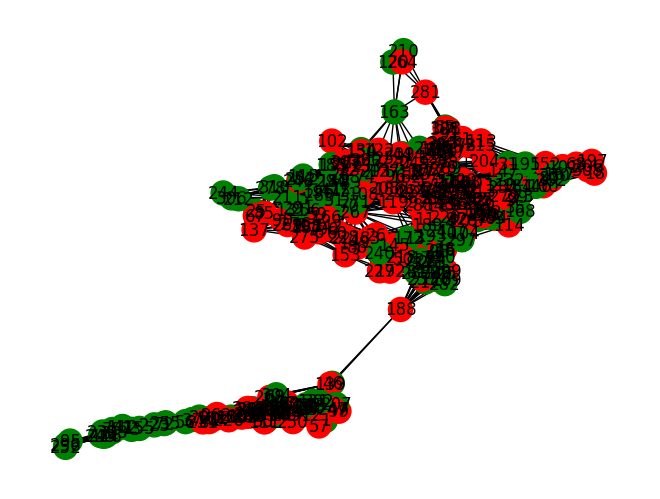

In [110]:
# Plot the graph with node colors based on the assigned clusters
colors = ['r', 'g', 'b', 'y']
node_colors = [colors[label] for label in kmeans.labels_]
nx.draw(G, with_labels=True, node_color=node_colors)
plt.show()

## Graph Dataset and Weighted Edges

In [111]:
dist_matrix = cdist(df[['X', 'Y']], df[['X', 'Y']])

# create an adjacency matrix where each node is connected to its three nearest neighbors
adj_matrix = np.zeros((len(df), len(df)))
for i in range(len(df)):
    sorted_indices = np.argsort(dist_matrix[i])[1:4]  # exclude self from nearest neighbors
    adj_matrix[i, sorted_indices] = 1
    adj_matrix[sorted_indices, i] = 1

# count the number of edges in the graph
num_edges = np.count_nonzero(adj_matrix) // 2  # divide by 2 since each edge is counted twice
print("Number of edges in the graph:", num_edges)
adj_matrix

edges = []
for i in range(adj_matrix.shape[0]):
    for j in range(i+1, adj_matrix.shape[1]):
        if adj_matrix[i][j] != 0:
            edges.append((i, j))

edges

weighted_edges = []
for edge in edges:
    weight = random.randint(1, 5)
    for i in range(weight):
        weighted_edges.append(edge)


len(weighted_edges)

Number of edges in the graph: 586


1723

## Convert Node Features and Edges to PyTorch Tensors

In [112]:
df = df[["X","Y"]]
node_features = df[["X", "Y"]]
# Convert to numpy
x = node_features.to_numpy()
x.shape # [num_nodes x num_features]

# Convert list of edges to tensor
edges_tensor = torch.tensor(weighted_edges, dtype=torch.long).t()

# Create edge_index tensor
edge_index = torch.cat([edges_tensor, edges_tensor.flip(dims=[0])], dim=1)

edge_index

tensor([[  0,   0,   0,  ..., 298, 298, 298],
        [  6,   6, 190,  ..., 289, 289, 289]])

In [113]:
data = Data(x=x, edge_index=edge_index)
from torch_geometric.loader import DataLoader
data_list = [Data(x=x, edge_index=edge_index), ..., Data(...)]
loader = DataLoader(data_list, batch_size=32)

data

data = train_test_split_edges(data)
data

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[311, 2], val_pos_edge_index=[2, 86], test_pos_edge_index=[2, 172], train_pos_edge_index=[2, 1126], train_neg_adj_mask=[311, 311], val_neg_edge_index=[2, 86], test_neg_edge_index=[2, 172])

# Approaches (Non-GNN)
 Use of https://scikit-learn.org/stable/modules/clustering.html#k-means


## Comparison Parameters



* **Density** - Number of vehicles over the square unit
* Avg Direction
* Signal Strength
* Percent Changed over time
* Elapsed Time
* Intervals of time
* Time to execute
* Cluster size / Avg Cluster Size
* No. of Vehicles
* Avg No. Hops
* Avg Distance from Infrastructure
* Cluster Head Distance from Infrastructure
* Dwell Time

## Display Parameters
https://medium.com/mlearning-ai/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f

In [133]:
# k = 2
K = range(1,10) # KMeans
clusters_num = 4 # This represents the number of clusters - KMeans, Spectral, Split and Merge,
n = 10 # This is the value used for n_init - KMeans, Spectral, Split and Merge,


# Get the adjacency matrix of the graph
A = nx.adjacency_matrix(G).todense()

# Define node colors based on the clusters (-1 represents outliers)
colors = ['black' if c == -1 else 'red' if c == 0 else 'green' if c == 1 else 'blue' if c == 2 else 'pink' if c == 3 else 'yellow' if c == 4 else 'orange' for c in clusters]

# TO DO
# - How does .fit(A) differ from .fit(embeddings)?
# k vs clusters_nums parameter
# Testing parameters for analysis - Dwell time, avg distance, computation time, avg # hops, density, avg direction, signal strength, percent change


ValueError: ignored

## K-Means (Non-GNN)
This approach comes from Nazanin's Github. The K-Means takes the number of clusters as a parameter and organizes accordingly.

This is a traditional approach that has been used to cluster vehicles that aims to minimize the within-cluster sum of squares (WCSS) or the sum of squared distances between objects and their centroid.

This approach does have limitations with managing clusters with varying sizes in desnities. We are looking to balance the sizes and densities of our clusters to evenly distribute the resources.

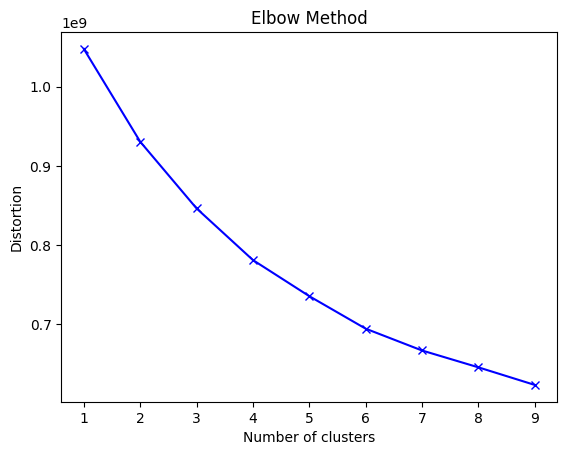

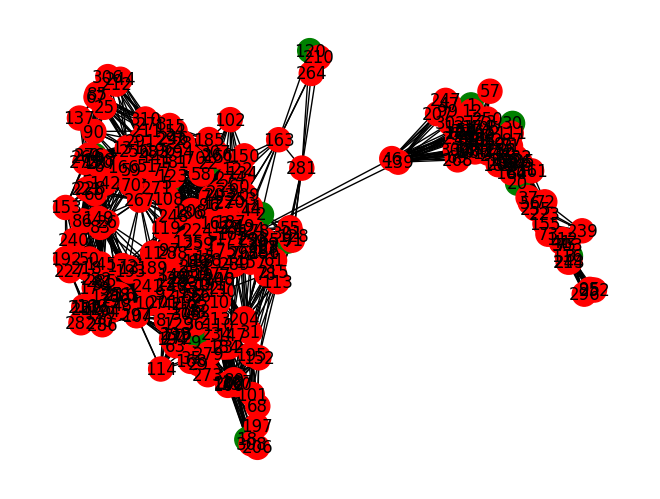

In [115]:
# Determine the optimal number of clusters using the elbow method
distortions = []

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=n).fit(A)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()


# Run K-means clustering on the adjacency matrix
kmeans = KMeans(n_clusters=clusters_num, n_init=n).fit(A)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

# Plot the graph with the nodes colored based on the clusters
nx.draw(G, with_labels=True, node_color=colors)
plt.show()

## Spectral (Non-GNN)

This approach comes from Nazanin's Github. The Spectral is based off of eigenvectors or spectrumof a similarity matrix or graph Laplacian.

This is a traditional approach that has been used to cluster vehicles is a combnination of graph theory, linear algebra, and clustering to determine low-dimensional embeddings.  This algorithm is best known for it's ability to handle limited linear separability. It takes in the number of clusters as a parameter. By looking at data point similarities and graphing. Eigenvectors determines the underlying structure of clusters through the low-frequency data components.

This approach does have limitations with noisy data resulting in incorrect assignments due to outliers. Similar to K-Means this algorithm also experiences challenges with varying densities as it favours compact densities.

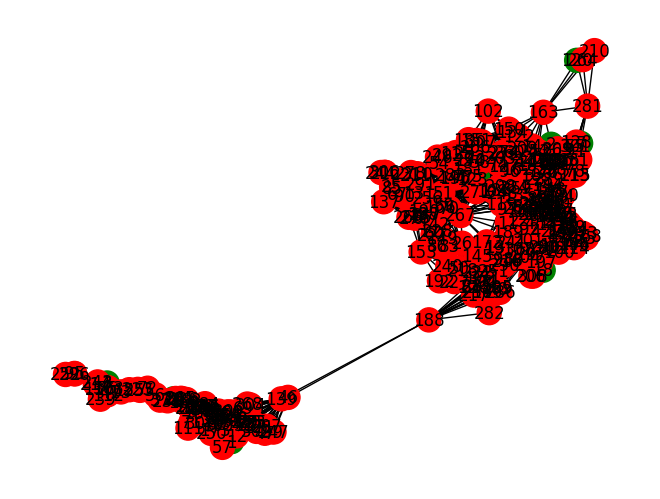

hi


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


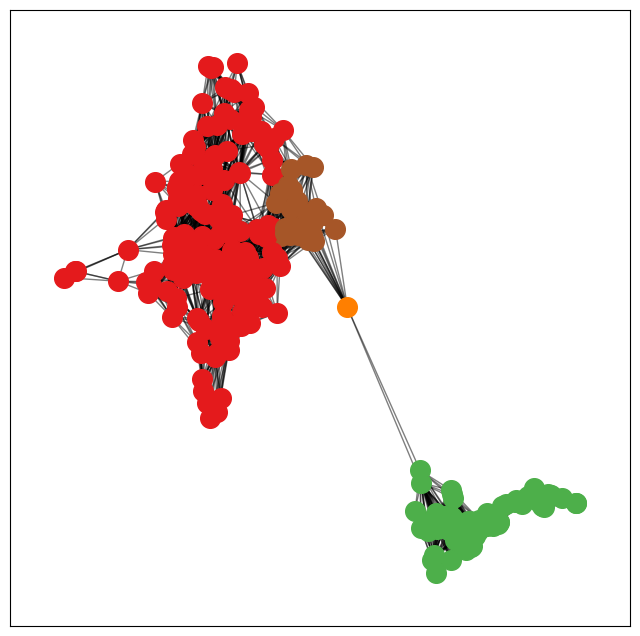

In [116]:
# Compute the Laplacian matrix
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=1))
L = D - A

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eig(L)

# Sort the eigenvalues and corresponding eigenvectors in ascending order
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Use the first two eigenvectors to create the embedding matrix
embedding = np.column_stack((eigenvectors[:,0], eigenvectors[:,1]))

# Apply K-means clustering on the embedding matrix
kmeans = KMeans(n_clusters=clusters_num, n_init=n).fit(embedding)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

# Plot the graph with the nodes colored based on the clusters
nx.draw(G, with_labels=True, node_color=colors)
plt.show()

print('hi')

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## Split and Merge
[Paper Citation](https://dl-acm-org.proxy.library.brocku.ca/doi/abs/10.1145/3479243.3487307)

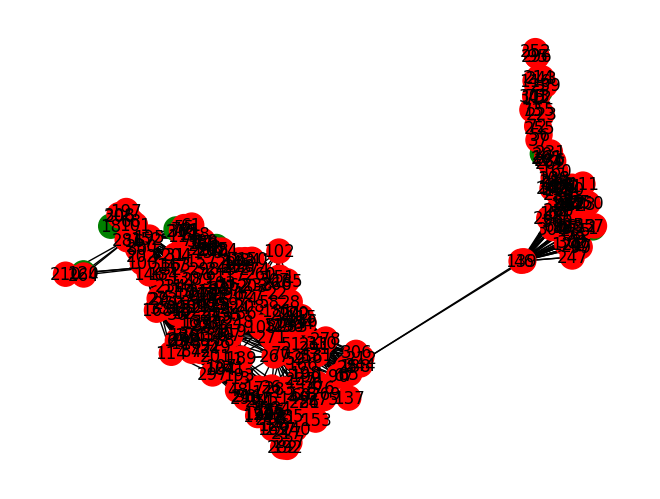

In [117]:
def split_method(cList, sList, k, theta):
    ssemax = max([SSE(c, s) for c in cList for s in sList])
    cList_hat = cList.copy()
    sList_hat = sList.copy()

    if ssemax > theta:
        ssemax_id = np.argmax([SSE(c, s) for c in cList for s in sList])
        SplitS = sList_hat.pop(ssemax_id)
        cList_hat.pop(ssemax_id)
        newC = kmeans(Kmax=2, data=SplitS)
        cList_hat.add(newC.cList)
        sList_hat.add(newC.sList)
        k_hat = k + 1
        return cList_hat, sList_hat, k_hat
    else:
        return cList_hat, sList_hat, k

def merge_method(cList, sList, beta, mk, path):
    ssemin = min([SSE(c, s) for c in cList for s in sList])

    if ssemin < beta and SSEmin > mk:
        ssemin_id = np.argmin([SSE(c, s) for c in cList for s in sList])
        C = cList[ssemin_id]
        S = sList[ssemin_id]
        for s in S:
            A = predict(s, cList, path)
            cList[A].add(s)
        k_hat = k - 1
        return cList, k_hat
    else:
        return cList, k

def SSE(c, s):
    # calculate SSE between cluster c and subset s
    pass

def kmeans(Kmax, data):
    kmeans = KMeans(n_clusters=Kmax)
    newC = kmeans.fit(data)
    return newC

def predict(Switch, cList, path):
    distance = [path[Switch][c] for c in cList]
    indxc = np.argmin(distance)
    sList[indxc].add(Switch)
    cList[indxc].load += Switch.load
    return indxc


# Run K-means clustering on the adjacency matrix
kmeans = KMeans(n_clusters=clusters_num, n_init=n).fit(A)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

## Affinity Propagation

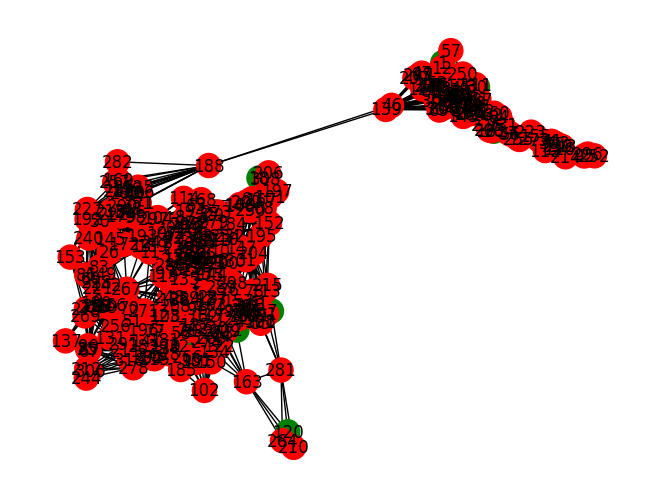

In [120]:
# Compute the similarity matrix using negative Euclidean distances
S = -pairwise_distances(A, metric='euclidean')

# Perform Affinity Propagation clustering
aff_prop = AffinityPropagation().fit(S)

# Get the cluster labels
clusters = aff_prop.labels_

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

## Mean Shift

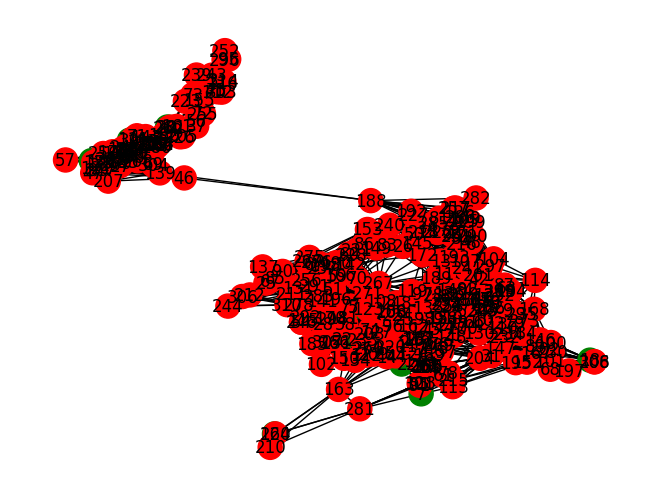

In [121]:
# Compute the similarity matrix using negative Euclidean distances
S = -pairwise_distances(A, metric='euclidean')

# Perform Mean Shift clustering
mean_shift = MeanShift().fit(S)

# Get the cluster labels
clusters = mean_shift.labels_

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

## Ward Hierarchical

In [122]:
# Compute the pairwise distance matrix
dist_matrix = squareform(A)

# Perform Ward hierarchical clustering
ward = AgglomerativeClustering(n_clusters=clusters_num, linkage='ward', affinity='euclidean').fit(dist_matrix)

# Get the cluster labels
clusters = ward.labels_

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

ValueError: ignored

## Agglomerative

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


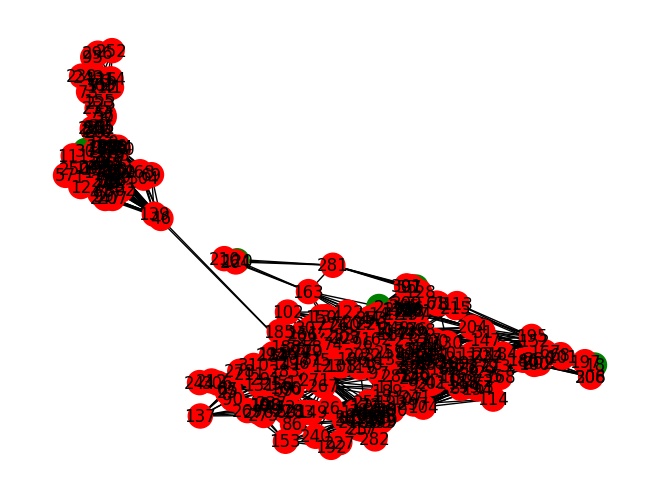

In [137]:
# Run K-means clustering on the adjacency matrix
kmeans = KMeans(n_clusters=clusters_num).fit(A)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

# Perform Agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=clusters_num, affinity='euclidean', linkage='ward').fit(A)

# Get the cluster labels
clusters = agglomerative.labels_

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()


## OPTICS

In [124]:
# Convert the adjacency matrix to a distance matrix
dist_matrix = np.sqrt(2 * (1 - A))

# Perform OPTICS clustering
optics = OPTICS(min_samples=2, xi=0.05, min_cluster_size=0.1)
optics.fit(dist_matrix)

# Get the cluster labels
clusters = optics.labels_

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

<ipython-input-124-a1925df55456>:2: RuntimeWarning: invalid value encountered in sqrt
  dist_matrix = np.sqrt(2 * (1 - A))


ValueError: ignored

## Guassian Mixtures

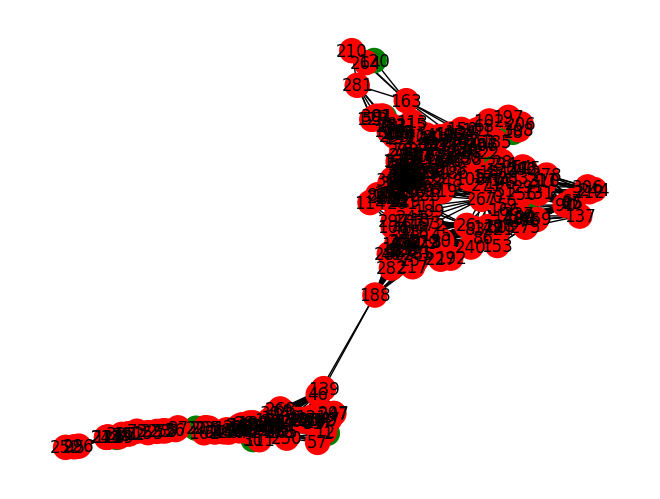

In [125]:
# Run Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=2)
gmm.fit(A)

# Assign the nodes to the corresponding clusters
clusters = gmm.predict(A)

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

## BIRCH

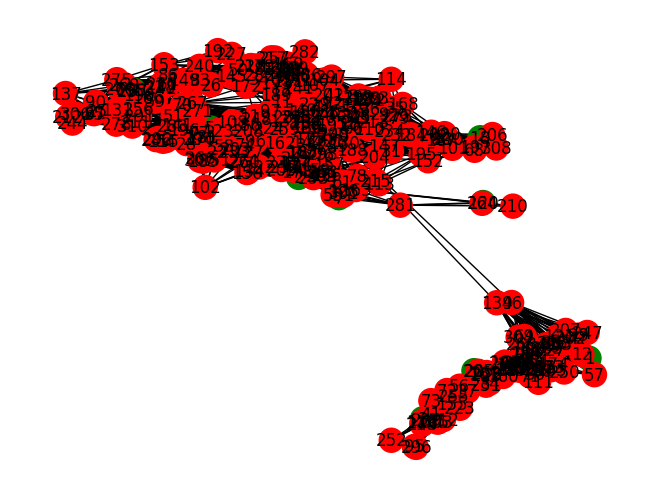

In [126]:
# Run BIRCH clustering
birch = Birch(n_clusters=2)
birch.fit(A)

# Assign the nodes to the corresponding clusters
clusters = birch.predict(A)

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

## Bi-Secting K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


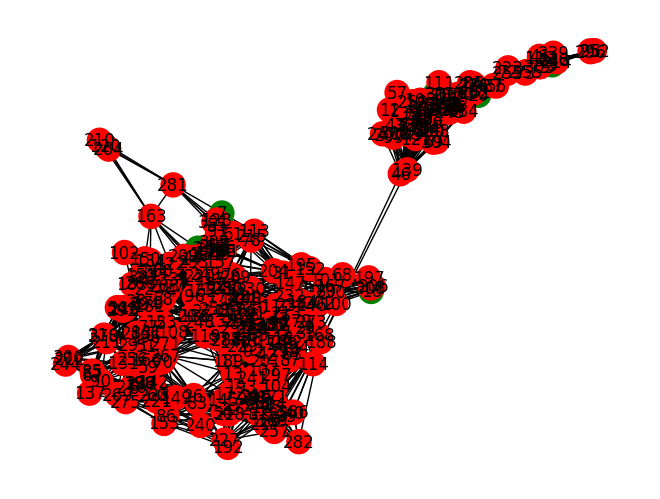

In [128]:
# Define the Bi-Secting K-Means function
def bi_secting_kmeans(X, k):
    clusters = []
    clusters.append(X)  # Start with the entire dataset as one cluster

    while len(clusters) < k:
        sse = []
        for cluster in clusters:
            kmeans = KMeans(n_clusters=2)
            kmeans.fit(cluster)
            sse.append(kmeans.inertia_)  # Compute SSE for each cluster

        # Find the cluster with the maximum SSE and split it into two
        max_sse_cluster_idx = np.argmax(sse)
        max_sse_cluster = clusters[max_sse_cluster_idx]
        kmeans = KMeans(n_clusters=clusters_num, n_init=n)
        kmeans.fit(max_sse_cluster)
        subclusters = kmeans.predict(max_sse_cluster)

        # Update the cluster list
        clusters.pop(max_sse_cluster_idx)
        clusters.append(max_sse_cluster[subclusters == 0])
        clusters.append(max_sse_cluster[subclusters == 1])

    return clusters

# Get the adjacency matrix of the graph
A = nx.adjacency_matrix(G).todense()

# Run Bi-Secting K-Means clustering
k = 2  # Number of clusters
clusters = bi_secting_kmeans(A, k)

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

## DBSCAN

In [130]:
# Convert the adjacency matrix to a distance matrix
dist_matrix = np.sqrt(2 * (1 - A))

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=2)
dbscan.fit(dist_matrix)

# Get the cluster labels
clusters = dbscan.labels_

# Plot the graph with the nodes colored based on the clusters
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=colors)
plt.show()

<ipython-input-130-426662da301a>:2: RuntimeWarning: invalid value encountered in sqrt
  dist_matrix = np.sqrt(2 * (1 - A))


NameError: ignored

## Spectral Co-Clustering

## Mini Batches KMeans

## Feature Agglomeration